In [1]:
%load_ext watermark
%watermark --datename --machine --python --packages numpy,pandas,sklearn

Mon Mar 30 2020 

CPython 3.8.2
IPython 7.12.0

numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2.post1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-91-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from IPython.core.display import HTML
from time import time

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

# Experiments

Define routines that generate synthetic standard normal data and run experiments.

In [3]:
def make_data(n_samples, n_features, random_state=32):
    np.random.seed(random_state)
    
    X_train = np.random.randn(n_samples, n_features)
    X_test = np.random.randn(10_000, n_features)
    
    normalize(X_train, norm='l2', copy=False)
    normalize(X_test, norm='l2', copy=False)
    
    return X_train, X_test

def run_experiment(make_data_params, nn_params):
    X_train, X_test = make_data(**make_data_params)
    algorithms = ['auto', 'brute', 'kd_tree', 'ball_tree']
    
    train_result, test_result = {}, {}
    for algo in algorithms:
        model = NearestNeighbors(**nn_params, algorithm=algo, n_jobs=1)
        
        if algo == 'auto':
            model.fit(X_train)
            train_result[algo] = test_result[algo] = model._fit_method
        else:
            fit_times, inf_times = [], []
            for _ in range(3):
                t0 = time()
                model.fit(X_train)
                t1 = time()
                model.kneighbors(X_test, return_distance=False)
                t2 = time()
                
                fit_times.append(t1 - t0)
                inf_times.append(t2 - t1)
            
            train_result[algo] = f'{np.mean(fit_times):.2f} sec ±{np.std(fit_times):.2f}'
            test_result[algo] = f'{np.mean(inf_times):.2f} sec ±{np.std(inf_times):.2f}'
    
    return (
        {**make_data_params, **nn_params, **train_result},
        {**make_data_params, **nn_params, **test_result}
    )

def run_experiment_2(make_data_params, nn_params):
    X_train, X_test = make_data(**make_data_params)
    model = NearestNeighbors(**nn_params, n_jobs=1)

    model.fit(X_train)
    
    start = time()
    model.kneighbors(X_test, return_distance=False)
    end = time()
    
    return {**make_data_params, **nn_params, 'time': np.mean(end - start)}

Define a grid of parameters to explore and create a generator yielding all combinations.

In [4]:
param_grid = {
    'n_samples': [10_000, 100_000],
    'n_features': [5, 10, 15, 30],
    'n_neighbors': [10, 150],
}

param_gen = (
    (
        {'n_samples': n_samples, 'n_features': n_features},
        {'n_neighbors': n_neighbors}
    )
    for n_samples, n_features, n_neighbors in \
    itertools.product(*param_grid.values())
)

Run all the experiments and split train/test results.

In [5]:
%%time

raw_results = [
    run_experiment(make_data_params, nn_params)
    for make_data_params, nn_params in param_gen
]

train_results, test_results = zip(*raw_results)

CPU times: user 52min 2s, sys: 4min, total: 56min 2s
Wall time: 48min 38s


Define another grid of parameters where only `n_features` evolves from 2 to 100. `n_samples` and `n_neighbors` are respectively fixed to 10,000 and 10.

In [6]:
param_grid = {
    'n_samples': [10_000],
    'n_features': list(range(2, 101)),
    'algorithm': ['brute', 'kd_tree', 'ball_tree'],
    'n_neighbors': [10],
}

param_gen = (
    (
        {'n_samples': n_samples, 'n_features': n_features},
        {'algorithm': algorithm, 'n_neighbors': n_neighbors}
    )
    for n_samples, n_features, algorithm, n_neighbors in \
    itertools.product(*param_grid.values())
)

Run all the experiments.

In [7]:
%%time

test_results_2 = [
    run_experiment_2(make_data_params, nn_params)
    for make_data_params, nn_params in param_gen
]

CPU times: user 25min, sys: 1min 43s, total: 26min 44s
Wall time: 23min 31s


# Results

Define routines to display the results.

In [8]:
def highlight_min_max(x):
    x = x.map(lambda x: float(x.split(' sec')[0]))
    
    is_max = x == x.max()
    is_min = x == x.min()
    
    min_color = 'background-color: lightgreen'
    max_color = 'background-color: lightcoral'
    
    return [
        min_color if val_is_min else max_color if val_is_max else ""
        for val_is_min, val_is_max in zip(is_min, is_max)
    ]


def style(results):
    results = pd.DataFrame(results).drop('n_neighbors', axis=1)
    results.set_index(['n_samples', 'n_features'], inplace=True)
    
    to_highlight = results.drop('auto', axis=1).columns
    styler = results.style.apply(
        highlight_min_max, subset=pd.IndexSlice[:, to_highlight], axis=1
    )
    
    return styler


def display(results, time):
    results_html = f"""
    <div align="center">
      <h3>{time} time (standard normal data)</h3>
      <table style="width: 85%;">
        <tr>
          <th><h3 align="center">n_neighbors = 10</h3></th>
          <th><h3 align="center">n_neighbors = 150</h3></th>
        </tr>
        <tr>
    """
    
    for n_neighbors in [10, 150]:
        results_filtered = (
            res for res in results if res['n_neighbors'] == n_neighbors
        )
        
        results_html += f"""
        <td><center>{style(results_filtered).render()}</center></td>
        """
    
    results_html += """
        </tr>
      </table>
    </div>
    """
    
    return HTML(results_html)


def plot_n_features(results):
    data = pd.DataFrame(results)
    algorithms = ['brute', 'kd_tree', 'ball_tree']

    fig, ax = plt.subplots(figsize=(10, 5))

    for algo in algorithms:
        temp = data.query('algorithm == @algo')
        ax.plot(temp['n_features'], temp['time'])

    ax.grid()
    ax.set_yscale('log')
    ax.set_title('Querying time (standard normal data)', fontsize=16)
    ax.set_xlabel('n_features', fontsize=14)
    ax.legend(labels=algorithms, loc='lower right', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

    plt.show()

Display 1st experiment training results.

In [9]:
display(train_results, time='Construction')

Display 1st experiment testing results.

In [10]:
display(test_results, time='Querying')

Plot `n_features` experiments.

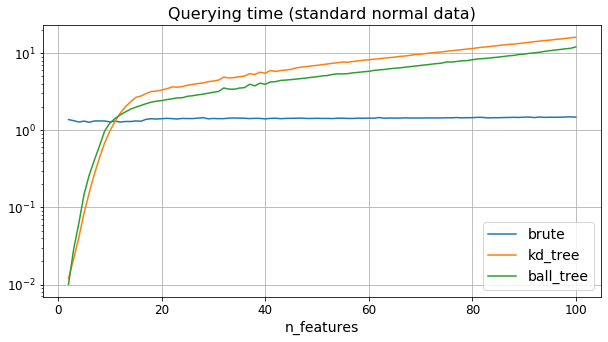

In [11]:
plot_n_features(test_results_2)